# RAPIDS & Scanpy Single-Cell RNA-seq Workflow on 1.3 Million Cells

Copyright (c) 2020, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This notebook demonstrates a single-cell RNA analysis workflow that begins with preprocessing a count matrix of size `(n_gene, n_cell)` and results in a visualization of the clustered cells for further analysis.

For demonstration purposes, we use a dataset of 1M brain cells with Unified Virtual Memory to oversubscribe GPU memory. See the README for instructions to download this dataset.

## Change to the notebooks directory

Change into the *notebooks* directory. You may need to modify your path depending on where you cloned the repo.

## Import requirements

In [2]:
import numpy as np
import scanpy as sc
import anndata

import dask
import time

import cudf
import cuml
import cupy as cp

import os, wget

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans

from dask_cuda import initialize, LocalCUDACluster
from dask.distributed import Client, default_client

import rapids_scanpy_funcs
import utils

import logging
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

We use the RAPIDS memory manager to enable Unified Virtual Memory management, which allows us to oversubscribe the GPU memory.

In [3]:
import rmm

def set_mem():
    rmm.reinitialize(managed_memory=True)
    cp.cuda.set_allocator(rmm.rmm_cupy_allocator)
    
cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES="0, 1, 2, 3, 4, 5, 6, 7")
client = Client(cluster)    

set_mem()
client.run(set_mem)

client

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34441,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:32875,Total threads: 1
Dashboard: http://127.0.0.1:36993/status,Memory: 125.97 GiB
Nanny: tcp://127.0.0.1:37017,


## Input data

In the cell below, we provide the path to the sparse `.h5ad` file containing the count matrix to analyze.

To run this notebook using your own dataset, please see the README for instructions to convert your own count matrix into this format. Then, replace the path in the cell below with the path to your generated `.h5ad` file.

In [4]:
input_file = "../data/1M_brain_cells_10X.sparse.h5ad"

if not os.path.exists(input_file):
    print('Downloading import file...')
    os.makedirs('../data', exist_ok=True)
    wget.download('https://rapids-single-cell-examples.s3.us-east-2.amazonaws.com/1M_brain_cells_10X.sparse.h5ad',
              input_file)

## Set parameters

In [5]:
# marker genes
MITO_GENE_PREFIX = "mt-" # Prefix for mitochondrial genes to regress out
markers = ["Stmn2", "Hes1", "Olig1"] # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
n_top_genes = 4000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 35 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

In [6]:
start = time.time()

## Load and Preprocess Data

In [7]:
data_load_preprocess_start = time.time()

Below, we load the sparse count matrix from the `.h5ad` file into GPU using a custom function. While reading the dataset, filters are applied on the count matrix to remove cells with an extreme number of genes expressed. Genes will zero expression in all cells are also eliminated. 

The custom function uses [Dask](https://dask.org) to partition data. The above mentioned filters are applied on individual partitions. Usage of Dask along with cupy provides the following benefits:
- Parallelized data loading when multiple GPUs are available
- Ability to partition the data allows pre-processing large datasets

Filters are applied on individual batches of cells. Elementwise or cell-level normalization operations are also performed while reading. For this example, the following two operations are performed:
- Normalize the count matrix so that the total counts in each cell sum to 1e4.
- Log transform the count matrix.

In [8]:
%%time
def partial_post_processor(partial_data):
    partial_data = rapids_scanpy_funcs.normalize_total(partial_data, target_sum=1e4)
    return partial_data.log1p()

dask_sparse_arr, genes, query = rapids_scanpy_funcs.read_with_filter(client,
                                                       input_file,
                                                       min_genes_per_cell=min_genes_per_cell,
                                                       max_genes_per_cell=max_genes_per_cell,
                                                       partial_post_processor=partial_post_processor)
dask_sparse_arr = dask_sparse_arr.persist()

CPU times: user 7.1 s, sys: 1.83 s, total: 8.94 s
Wall time: 42.2 s


Verify the shape of the resulting sparse matrix:

In [9]:
dask_sparse_arr.shape

(1306127, 24002)

### Select Most Variable Genes

Before filtering the count matrix, we save the 'raw' expression values of the marker genes to use for labeling cells afterward.

In [10]:
%%time
marker_genes_raw = {}
i = 0
for index in genes[genes.isin(markers)].index.to_arrow().to_pylist():
    marker_genes_raw[markers[i]] = dask_sparse_arr[:, index].compute().toarray().ravel()
    i += 1

CPU times: user 850 ms, sys: 327 ms, total: 1.18 s
Wall time: 7.09 s


Filter the count matrix to retain only the most variable genes.

In [11]:
%%time

hvg = rapids_scanpy_funcs.highly_variable_genes_filter(client, dask_sparse_arr, genes, n_top_genes=n_top_genes)

genes = genes[hvg]
dask_sparse_arr = dask_sparse_arr[:, hvg]
sparse_gpu_array = dask_sparse_arr.compute()

# del dask_sparse_arr
del hvg

CPU times: user 2.19 s, sys: 5.07 s, total: 7.26 s
Wall time: 9.09 s


### Regress out confounding factors (number of counts, mitochondrial gene expression)

We can now perform regression on the count matrix to correct for confounding factors -  for example purposes, we use the number of counts and the expression of mitochondrial genes (named starting with `mt-`).

We now calculate the total counts and the percentage of mitochondrial counts for each cell.

In [12]:
%%time
sparse_gpu_array = sparse_gpu_array.tocsc()

mito_genes = genes.str.startswith(MITO_GENE_PREFIX).values
n_counts = sparse_gpu_array.sum(axis=1)
percent_mito = (sparse_gpu_array[:,mito_genes].sum(axis=1) / n_counts).ravel()

n_counts = cp.array(n_counts).ravel()
percent_mito = cp.array(percent_mito).ravel()

CPU times: user 484 ms, sys: 277 ms, total: 761 ms
Wall time: 751 ms


In [13]:
del sparse_gpu_array

And perform regression:

In [14]:
%%time
n_rows = dask_sparse_arr.shape[0]
n_cols = dask_sparse_arr.shape[1]
dask_sparse_arr = dask_sparse_arr.map_blocks(lambda x: x.todense(), dtype="float32", meta=cp.array(cp.zeros((0,)))).T
dask_sparse_arr = dask_sparse_arr.rechunk((500, n_rows)).persist()
dask_sparse_arr.compute_chunk_sizes()

CPU times: user 1.41 s, sys: 469 ms, total: 1.88 s
Wall time: 20.6 s


dask.array<rechunk-merge, shape=(4000, 1291337), dtype=float32, chunksize=(500, 1291337), chunktype=cupy.ndarray>

In [15]:
%%time
import math
dask_sparse_arr = dask_sparse_arr.map_blocks(lambda x: rapids_scanpy_funcs.regress_out(x.T, n_counts, percent_mito).T, dtype="float32", meta=cp.array(cp.zeros(0,))).T
dask_sparse_arr = dask_sparse_arr.rechunk((math.ceil(n_rows/8), n_cols)).persist()
dask_sparse_arr.compute_chunk_sizes()

CPU times: user 2.41 s, sys: 1.09 s, total: 3.5 s
Wall time: 36 s


dask.array<rechunk-merge, shape=(1291337, 4000), dtype=float32, chunksize=(163266, 4000), chunktype=cupy.ndarray>

### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations, obtaining the preprocessed count matrix.

In [16]:
%%time
mean = dask_sparse_arr.mean(axis=0)
dask_sparse_arr -= mean
stddev = cp.sqrt(dask_sparse_arr.var(axis=0).compute())
dask_sparse_arr /= stddev
dask_sparse_arr = dask.array.clip(dask_sparse_arr, -10, 10).persist()
del mean, stddev

CPU times: user 185 ms, sys: 66.9 ms, total: 252 ms
Wall time: 2.02 s


In [17]:
data_load_preprocess_time = time.time()
print("Total data load and preprocessing time: %s" % (data_load_preprocess_time-data_load_preprocess_start))

Total data load and preprocessing time: 117.95534157752991


## Cluster & Visualize

### Reduce

We use PCA to reduce the dimensionality of the matrix to its top 50 principal components.

In [18]:
%%time
from cuml.dask.decomposition import PCA
pca_data = PCA(n_components=50).fit_transform(dask_sparse_arr)
pca_data.compute_chunk_sizes()

CPU times: user 895 ms, sys: 229 ms, total: 1.12 s
Wall time: 11.6 s


dask.array<concatenate, shape=(1291337, 50), dtype=float32, chunksize=(163266, 50), chunktype=cupy.ndarray>

We store the preprocessed count matrix as an AnnData object, which is currently in host memory. We also add the expression levels of the marker genes as observations to the annData object.

In [19]:
%%time
local_pca = pca_data.compute()
adata = anndata.AnnData(local_pca.get())

CPU times: user 1.14 s, sys: 678 ms, total: 1.82 s
Wall time: 3.65 s


In [20]:
pca_data.shape

(1291337, 50)

### t-SNE + K-means

We cluster the cells using k-means on the principal components. For example purposes, we set k=35.

In [21]:
%%time
adata.obsm['X_tsne'] = TSNE().fit_transform(adata.X[:,:tsne_n_pcs])

[W] [13:05:49.479125] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 33.9 s, sys: 19.1 s, total: 53 s
Wall time: 52.4 s


In [22]:
%%time
from cuml.dask.cluster import KMeans
kmeans_labels = KMeans(n_clusters=k, init="k-means||", random_state=0).fit_predict(pca_data)
adata.obs['kmeans'] = kmeans_labels.compute().get().astype(str)

CPU times: user 1.07 s, sys: 217 ms, total: 1.29 s
Wall time: 8.47 s


We visualize the cells using t-SNE and label cells by color according to the k-means clustering.

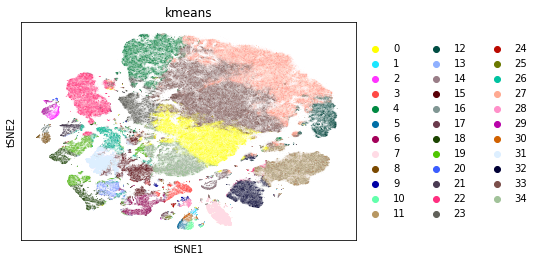

CPU times: user 8.12 s, sys: 1.85 s, total: 9.96 s
Wall time: 7.82 s


In [23]:
%%time
sc.pl.tsne(adata, color=["kmeans"])

### UMAP + Graph clustering

We can also visualize the cells using the UMAP algorithm in Rapids. Before UMAP, we need to construct a k-nearest neighbors graph in which each cell is connected to its nearest neighbors. This can be done conveniently using rapids functionality already integrated into Scanpy.

Note that Scanpy uses an approximation to the nearest neighbors on the CPU while the GPU version performs an exact search. While both methods are known to yield useful results, some differences in the resulting visualization and clusters can be observed.

The UMAP function from Rapids is also integrated into Scanpy.

In [24]:
%%time
from cuml.dask.manifold import UMAP as DaskUMAP
from cuml.manifold import UMAP

umap_train = pca_data[:int(0.10*pca_data.shape[0])].compute()
umap = UMAP(min_dist=umap_min_dist, spread=umap_spread).fit(umap_train)

CPU times: user 602 ms, sys: 361 ms, total: 963 ms
Wall time: 2.86 s


In [25]:
%%time
adata.obsm["X_umap"] = DaskUMAP(umap).transform(pca_data).compute().get()

CPU times: user 495 ms, sys: 109 ms, total: 604 ms
Wall time: 6.78 s


We can distribute the computation of the nearest neighbors graph for graph-based clustering

In [26]:
%%time
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')

CPU times: user 55 s, sys: 11.9 s, total: 1min 6s
Wall time: 1min 4s


Next, we use the Louvain algorithm for graph-based clustering.

In [27]:
%%time
sc.tl.louvain(adata, flavor='rapids')

CPU times: user 2.56 s, sys: 864 ms, total: 3.42 s
Wall time: 3.33 s


We plot the cells using the UMAP visualization, and using the Louvain clusters as labels.

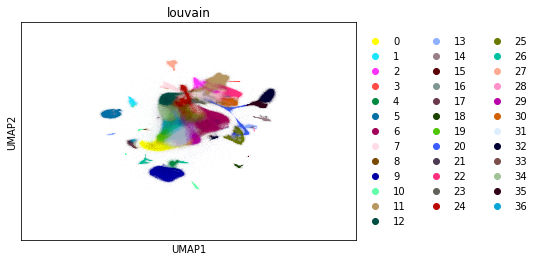

CPU times: user 7.17 s, sys: 1.02 s, total: 8.19 s
Wall time: 6.96 s


In [28]:
%%time
sc.pl.umap(adata, color=["louvain"])

We can also use the Leiden clustering method in RAPIDS. This method has not been integrated into Scanpy and needs to be called separately.

In [29]:
%%time
adata.obs['leiden'] = rapids_scanpy_funcs.leiden(adata)

CPU times: user 1.86 s, sys: 884 ms, total: 2.75 s
Wall time: 2.7 s


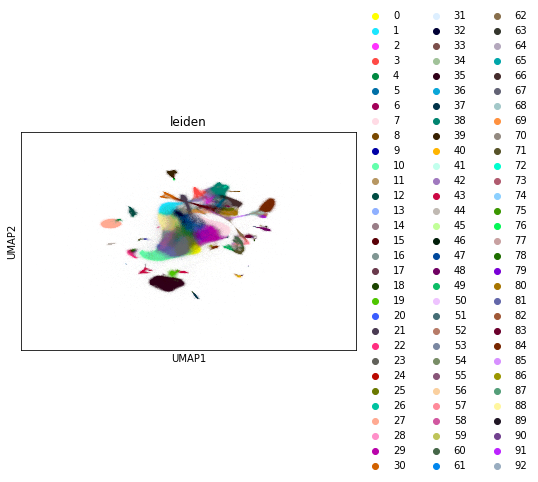

CPU times: user 10.5 s, sys: 2.73 s, total: 13.2 s
Wall time: 9.48 s


In [30]:
%%time
sc.pl.umap(adata, color=["leiden"])

## Differential expression analysis

Once we have done clustering, we can compute a ranking for the highly differential genes in each cluster. Here we use the Louvain clusters as labels.

In [27]:
import cudf
cluster_labels = cudf.Series.from_categorical(adata.obs["louvain"].cat)
genes = cudf.Series(genes)

We use logistic regression to identify the top 50 genes distinguishing each cluster.

In [28]:
genes

0                Xkr4
1               Sox17
2             Gm37323
3               Oprk1
4       4732440D04Rik
            ...      
3995           mt-Nd6
3996       AC133103.1
3997       AC132444.6
3998       AC125149.3
3999             PISD
Length: 4000, dtype: object

In [29]:
%%time

import cupy as cp
scores, names, reference = rapids_scanpy_funcs.rank_genes_groups(
    cp.array(adata.X), 
    cluster_labels, 
    genes, 
    n_genes=50, groups='all', reference='rest')

[ True  True  True ...  True  True  True]
[W] [13:27:56.288959] L-BFGS: max iterations reached
[W] [13:27:56.292433] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
CPU times: user 2min 30s, sys: 57.5 s, total: 3min 27s
Wall time: 3min 27s


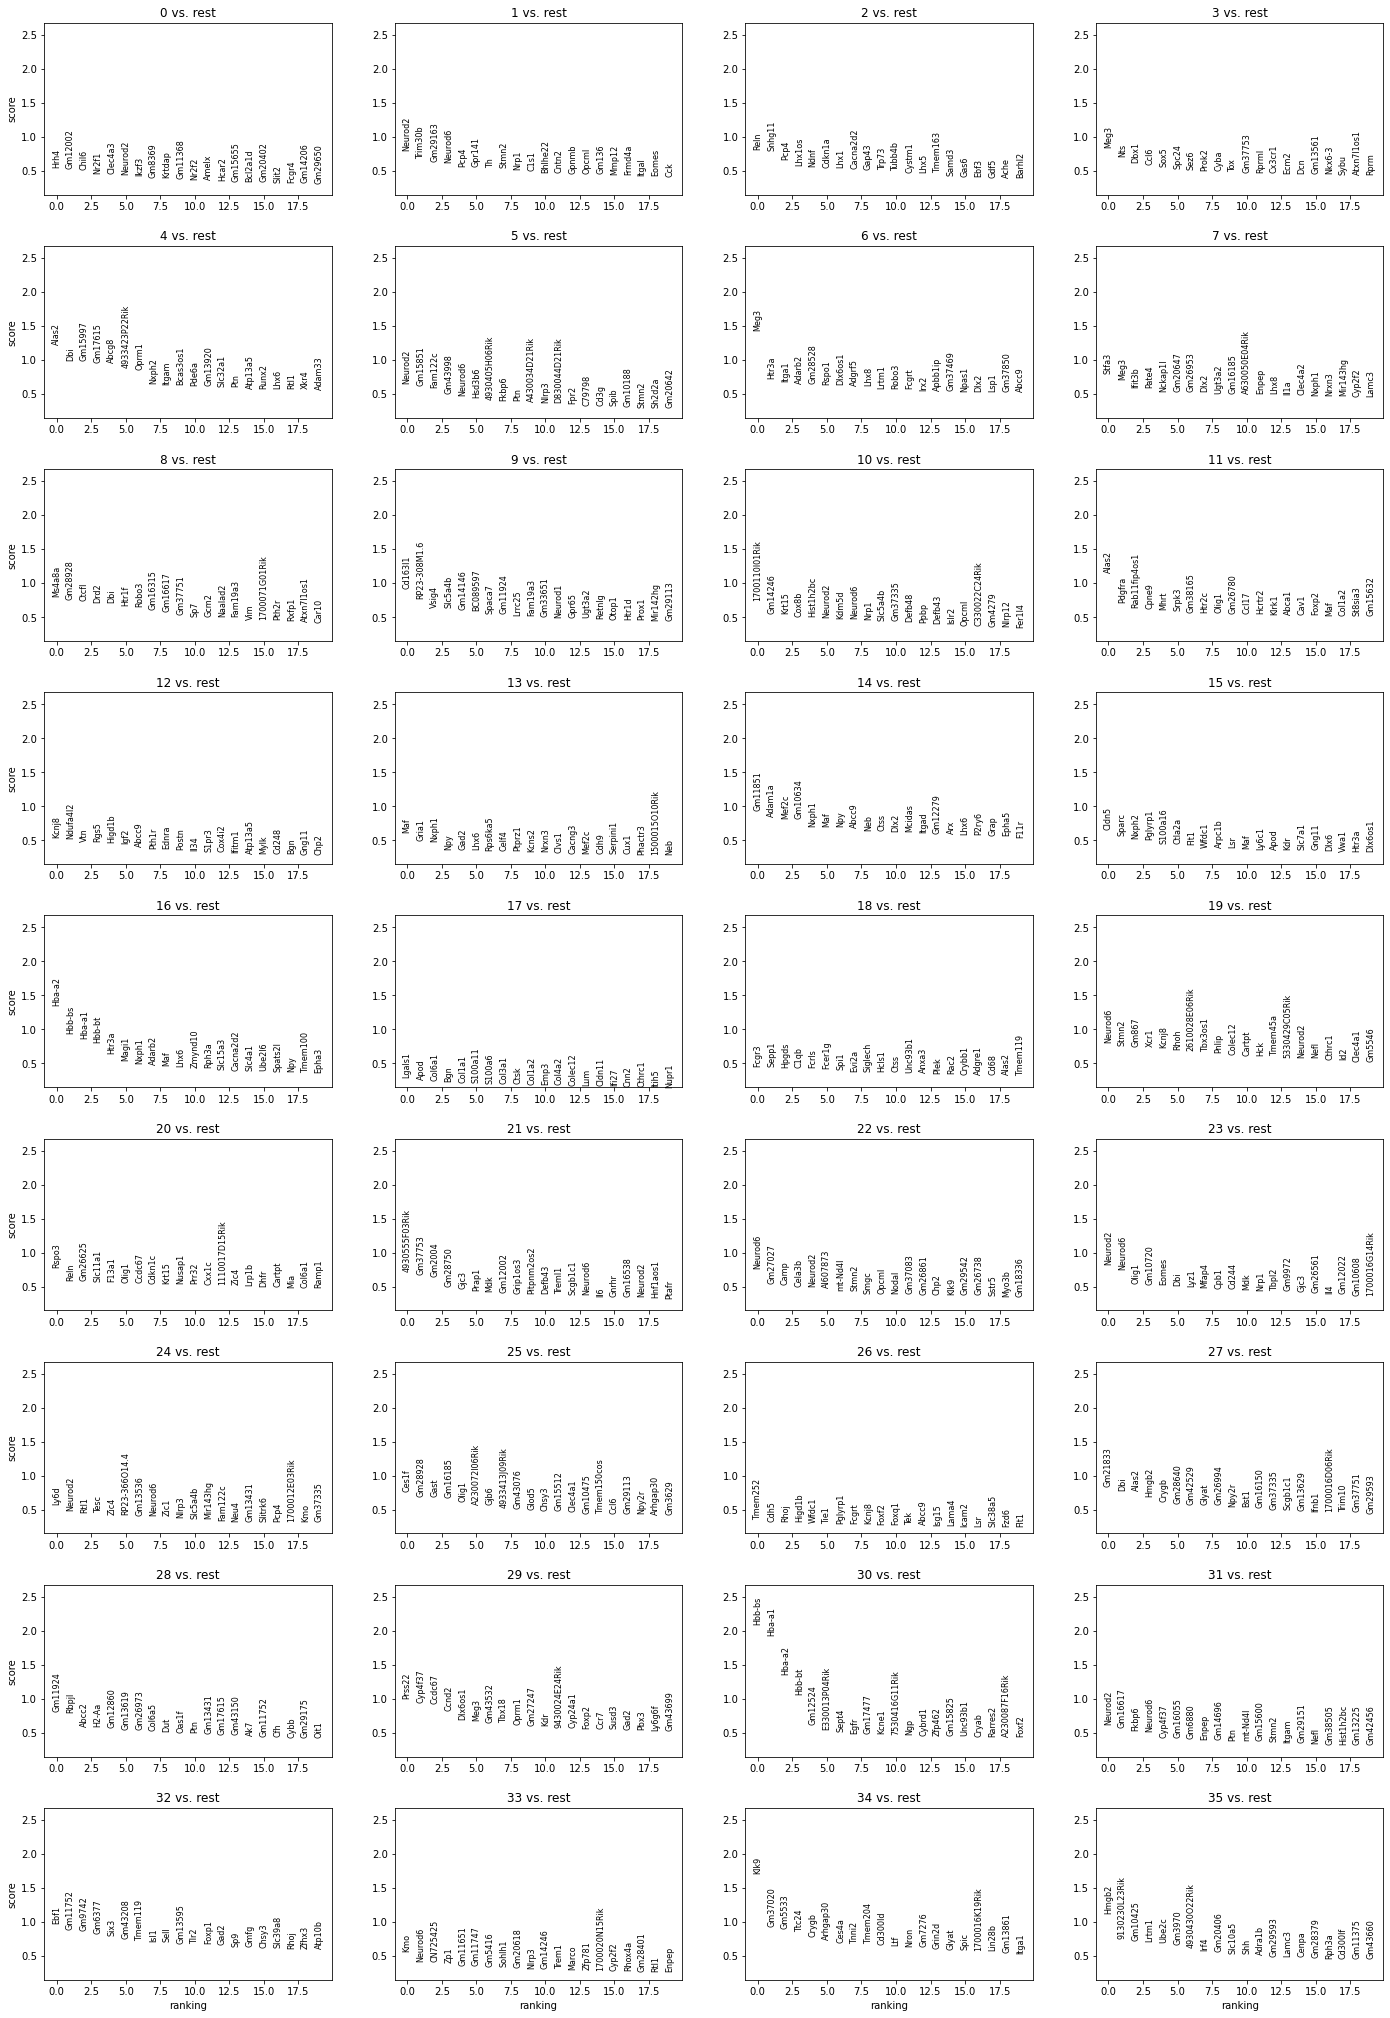

CPU times: user 5.74 s, sys: 3.46 s, total: 9.21 s
Wall time: 8.96 s


In [30]:
%%time
adata.uns["rank_genes_groups"] = {}
adata.uns["rank_genes_groups"]["params"] = dict(groupby="louvain", method="logreg", reference=reference, use_raw=False)
adata.uns["rank_genes_groups"]['scores'] = scores
adata.uns["rank_genes_groups"]['names'] = names
sc.pl.rank_genes_groups(adata, n_genes=20)

In [31]:
print("Full time: %s" % (time.time() - start))

client.shutdown()
cluster.close()

Full time: 299.02070474624634


TypeError: Level not an integer or a valid string: None

Failed to reconnect to scheduler after 30.00 seconds, closing client
